## Оглавление


* [Описание данных](#chapter_1)
* [1. Импорт библиотек и загрузка зависимостей](#chapter_2)
* [2. EDA-анализ](#chapter_3)
    * [2.1. Общая информация](#chapter_2_1)
    * [2.2. Пропуски и дубликаты](#chapter_2_2)
    * [2.3. Распределения числовых признаков](#chapter_2_3)
    * [2.4. Число уникальных значений в категориальных признаках](#chapter_2_4)
    * [2.5. Матрица Phi_K корреляции](#chapter_2_5)
* [3. Feature Engineering](#chapter_4)
    * [3.1. Обработка файлов](#chapter_4_1)
    * [3.2. Разделение выборки для валидации](#chapter_4_2)
    * [3.3. Обучение CatBoostRegressor](#chapter_4_3)
    * [3.4. График Q-Q Plot](#chapter_4_4)


## Описание данных <a id="chapter_1"></a>

- name: название объекта
- _id: уникальный идентификатор
- host_name: имя владельца или хоста, который предоставляет жилье
- location_cluster: кластеризация местоположений (например, группировка объектов по районам или зонам).
- location: описание местоположения объекта
- lat, lon: широта и долгота местоположения объекта.
- type_house: тип жилья
- sum: общая стоимость аренды или сумма за определенный период.
- min_days: минимальное количество дней для бронирования объекта.
- amt_reviews: количество отзывов, оставленных для данного объекта.
- last_dt: дата последнего отзыва или последнего бронирования.
- avg_reviews: средний рейтинг или среднее количество отзывов за определенный период.
- total_host: общее количество объектов, принадлежащих одному хосту
- target: целевая переменная

## 1. Импорт библиотек и загрузка зависимостей <a class="anchor" id="chapter_2"></a>

In [ ]:
%autosave 60

Autosaving every 60 seconds


In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"deniss546","key":"eed486653ed7d24eec0b7035dcbbe60c"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c teta-ml-2-2025
!unzip /content/teta-ml-2-2025.zip
!rm teta-ml-2-2025.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 4.3 MB/s eta 0:00:00
  0% 0.00/2.26M [00:00<?, ?B/s]
100% 2.26M/2.26M [00:00<00:00, 128MB/s]
Archive:  /content/teta-ml-2-2025.zip
  inflating: sample_submition.csv    
  inflating: solution.csv            
  inflating: test.csv                
  inflating: train.csv               


In [3]:
# !pip install reverse_geocoder
# !pip install category_encoders
# !pip install -U catboost
# !pip install phik

In [4]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import reverse_geocoder as rg
import seaborn as sns
from catboost import CatBoostRegressor, cv, Pool
from geopy.distance import great_circle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (train_test_split, KFold)
import warnings
from scipy.stats import norm
from phik import phik_matrix
import statsmodels.api as sm

## 2. EDA-анализ <a id="chapter_3"></a>

### 2.1 Общая информация <a id="chapter_2_1"></a>

In [5]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")
df_train.head(1)

,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,last_dt,avg_reviews,total_host,target
0,Belle Harbor 4 BR 2 bath- 1 bl from Beach,40327248,Sarina,Queens,Neponsit,40.57215,-73.85822,Entire home/apt,350,2,5,2019-07-07,2.88,1,334


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36671 entries, 0 to 36670
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              36662 non-null  object 
 1   _id               36671 non-null  int64  
 2   host_name         36653 non-null  object 
 3   location_cluster  36671 non-null  object 
 4   location          36671 non-null  object 
 5   lat               36671 non-null  float64
 6   lon               36671 non-null  float64
 7   type_house        36671 non-null  object 
 8   sum               36671 non-null  int64  
 9   min_days          36671 non-null  int64  
 10  amt_reviews       36671 non-null  int64  
 11  last_dt           29169 non-null  object 
 12  avg_reviews       29169 non-null  float64
 13  total_host        36671 non-null  int64  
 14  target            36671 non-null  int64  
dtypes: float64(3), int64(6), object(6)
memory usage: 4.2+ MB


In [7]:
df_train.describe()

,_id,lat,lon,sum,min_days,amt_reviews,avg_reviews,total_host,target
count,3.667100e+04,36671.000000,36671.000000,36671.000000,36671.000000,36671.000000,29169.000000,36671.000000,36671.000000
mean,6.720433e+07,40.729080,-73.951958,152.142292,7.053176,23.433667,1.365601,7.047694,112.766628
std,7.828147e+07,0.054671,0.046201,239.107973,21.539569,44.703590,1.643966,32.595427,131.583284
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,7.780024e+06,40.690090,-73.982970,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,3.053256e+07,40.723150,-73.955560,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,1.074344e+08,40.763260,-73.935865,175.000000,5.000000,24.000000,2.010000,2.000000,227.000000
max,2.743213e+08,40.912340,-73.712990,10000.000000,1250.000000,629.000000,20.940000,327.000000,365.000000


### 2.2 Пропуски и дубликаты <a id="chapter_2_2"></a>

In [8]:
missing = df_train.isnull().sum()
missing = missing[missing > 0]

print('Данные, которые содержат пропуски (df_train):')
print(pd.DataFrame({'Количество пропусков': missing,
                    'Доля в %': (missing/len(df_train)*100).round(2)}))

Данные, которые содержат пропуски (df_train):
             Количество пропусков  Доля в %
name                            9      0.02
host_name                      18      0.05
last_dt                      7502     20.46
avg_reviews                  7502     20.46


In [9]:
missing = df_test.isnull().sum()
missing = missing[missing > 0]

print('Данные, которые содержат пропуски (df_test):')
print(pd.DataFrame({'Количество пропусков': missing,
                    'Доля в %': (missing/len(df_test)*100).round(2)}))

Данные, которые содержат пропуски (df_test):
             Количество пропусков  Доля в %
name                            7      0.06
host_name                       3      0.02
last_dt                      2550     20.86
avg_reviews                  2550     20.86


### 2.3 Распределения числовых признаков <a id="chapter_2_3"></a>

In [10]:
numerical_columns = df_train.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df_train.select_dtypes(include=['object']).columns

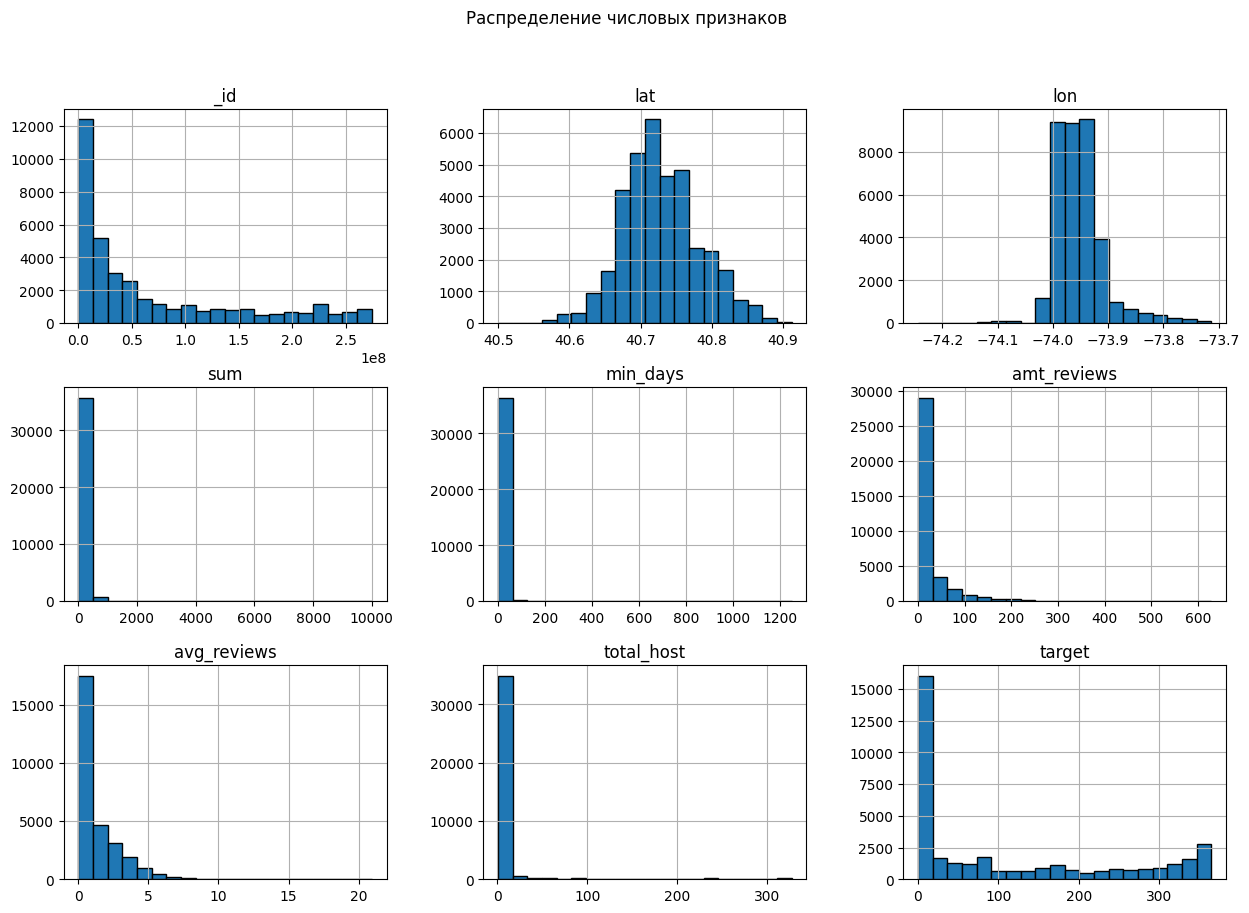

In [11]:
df_train.select_dtypes(include=['int64', 'float64']).hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.suptitle('Распределение числовых признаков')
plt.show()

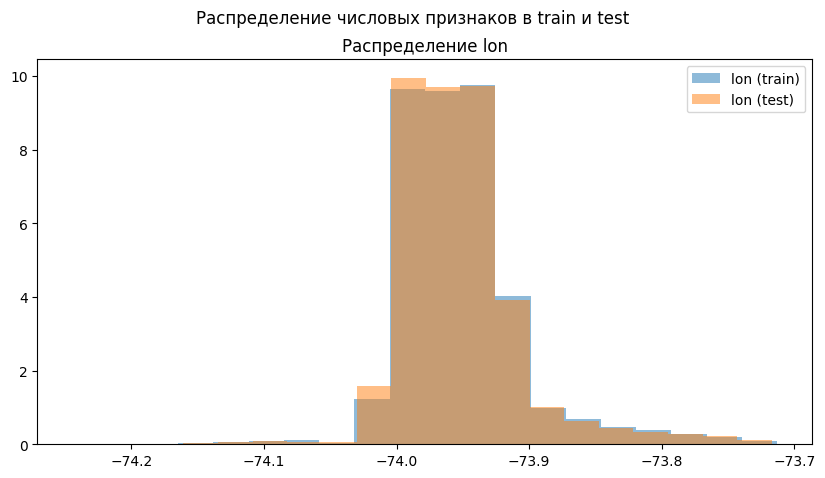

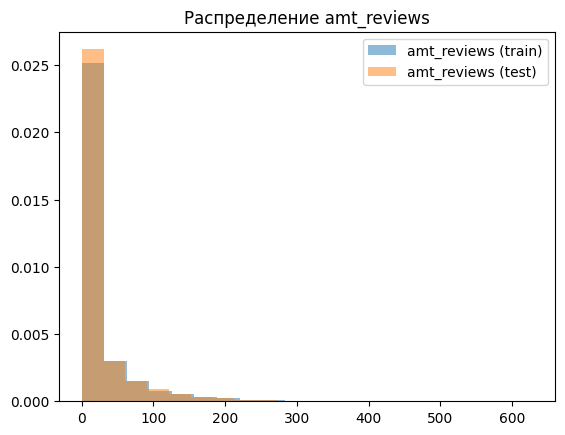

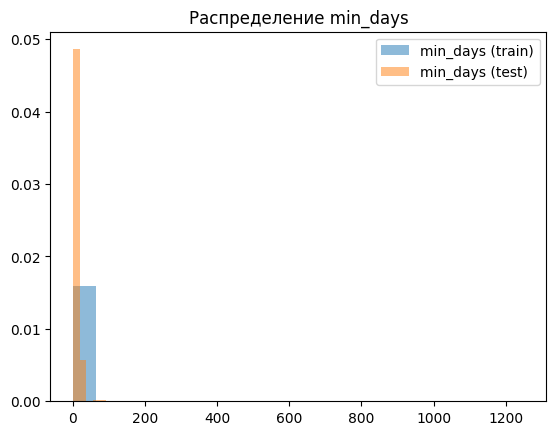

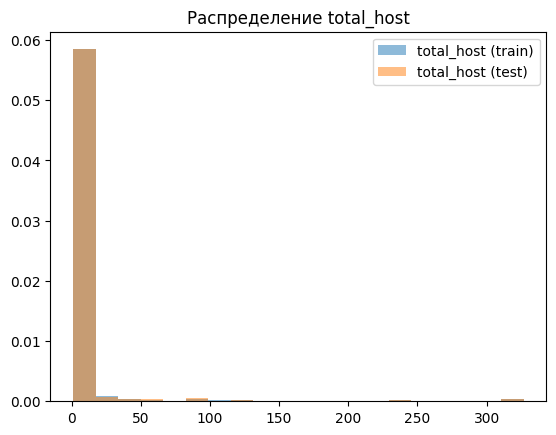

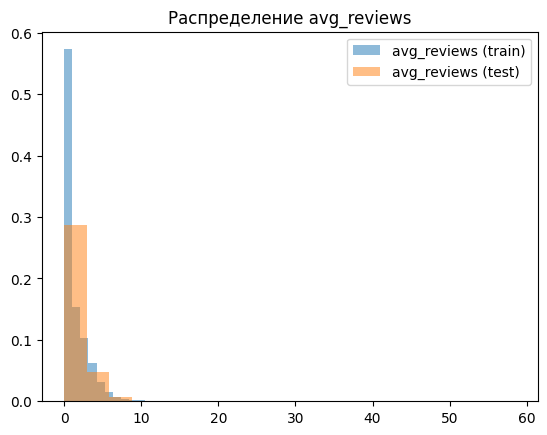

<ipython-input-12-f7fd6270673d>:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


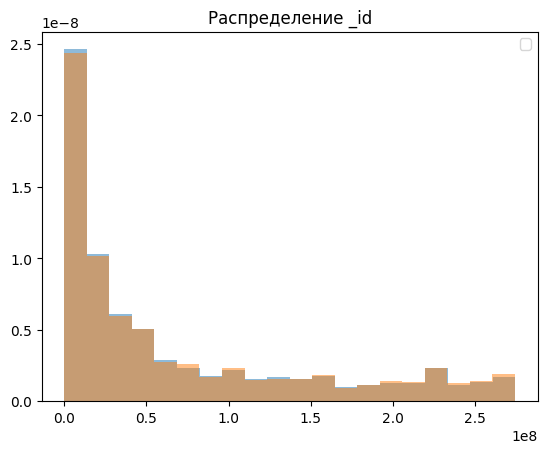

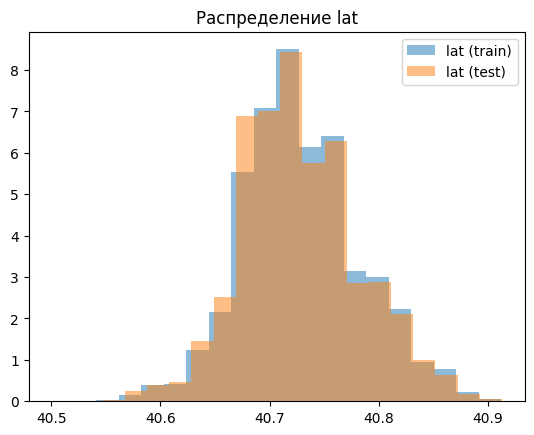

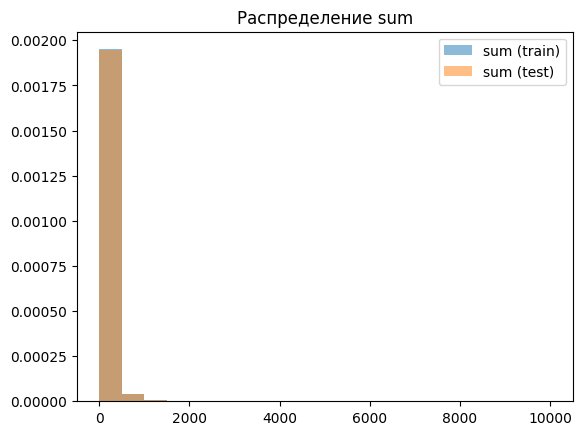

In [12]:
numerical_columns_test = df_test.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(10, 5))
plt.suptitle('Распределение числовых признаков в train и test')

for col in set(numerical_columns).intersection(numerical_columns_test):
    plt.hist(df_train[col], alpha=0.5, label=f'{col} (train)', bins=20, density=True)
    plt.hist(df_test[col], alpha=0.5, label=f'{col} (test)', bins=20, density=True)
    plt.title(f'Распределение {col}')
    plt.legend()
    plt.show()

Распределения в файлах схожи

### 2.4 Число уникальных значений в категориальных признаках <a id="chapter_2_4"></a>

In [13]:
print('Число уникальных значений в категориальных признаках:')
print(df_train[categorical_columns].nunique().sort_values(ascending=False))

Число уникальных значений в категориальных признаках:
name                36076
host_name            9629
last_dt              1694
location              220
location_cluster        5
type_house              3
dtype: int64


Стоит обратить внимание на то, что 'last_dt' это признак, который содержит информацию о датах

### 2.5 Матрица Phi_K корреляции <a id="chapter_2_5"></a>

In [14]:
# исключение признаков с очень большим числом уникальных значений, чтобы ускорить вычисление
exclude_cols = ['name', 'host_name', 'last_dt']
df_phik = df_train.drop(columns=exclude_cols, errors='ignore')

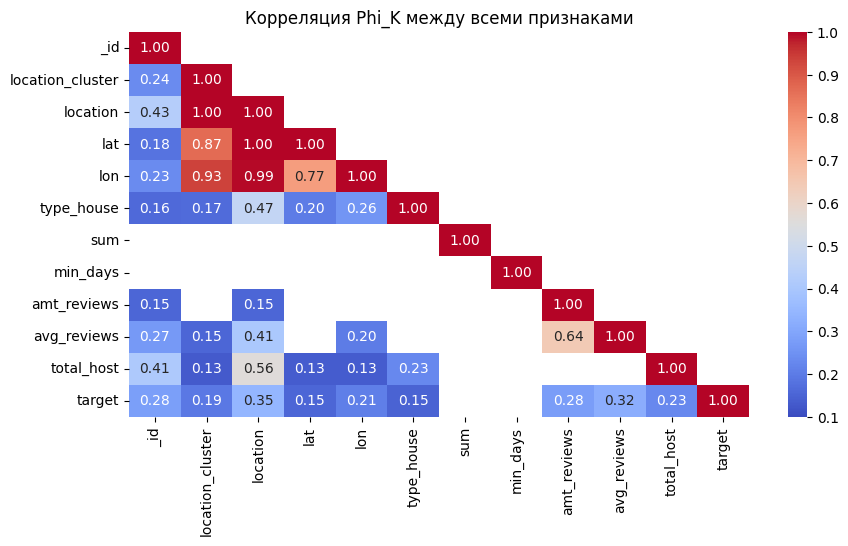

In [15]:
phik_corr = df_phik.phik_matrix(interval_cols=numerical_columns)

# маска и фильтрация слабых значений
mask_phik = np.triu(np.ones_like(phik_corr, dtype=bool), k=1)
phik_corr_filtered = phik_corr.copy()
phik_corr_filtered[phik_corr_filtered < 0.1] = np.nan

plt.figure(figsize=(10, 5))
sns.heatmap(phik_corr_filtered, mask=mask_phik, annot=True, fmt='.2f',
            cmap='coolwarm', vmin=0.1, vmax=1)
plt.title("Корреляция Phi_K между всеми признаками")
plt.show()

## 3. Feature Engineering <a id="chapter_4"></a>

In [16]:
train_copy = df_train.copy()
test_copy = df_test.copy()

### 3.1 Обработка файлов <a id="chapter_4_1"></a>

Функции 'haversine_distance' и 'bearing_degree' предложенные на лекции:

In [17]:
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
        Функция для расчёта расстояния от точки А до Б по прямой

        :param lat1: Широта точки А
        :param lon1: Долгота точки А
        :param lat2: Широта точки Б
        :param lon2: Долгота точки Б
        :param n_digits: Округляем полученный ответ до n знака после запятой
        :return: Дистанция по прямой с точностью до n_digits
    """

    lat1, lon1, lat2, lon2 = round(lat1, 6), round(lon1, 6), round(lat2, 6), round(lon2, 6)
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)

    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2

    return round(2 * 6372800 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)), n_digits)  # метры.сантиметры


def bearing_degree(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
        Функция для расчёта угла между прямой [((lat1, lon1), (lat2, lon2)), (нулевой мередиан)]

        :param lat1: Широта точки А
        :param lon1: Долгота точки А
        :param lat2: Широта точки Б
        :param lon2: Долгота точки Б
        :param n_digits: Округляем полученный ответ до n знака после запятой
        :return: Значение угла с точностью до n_digits
    """

    lat1, lon1 = np.radians(round(lat1, 6)), np.radians(round(lon1, 6))
    lat2, lon2 = np.radians(round(lat2, 6)), np.radians(round(lon2, 6))

    dlon = (lon2 - lon1)
    numerator = np.sin(dlon) * np.cos(lat2)
    denominator = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

    theta = np.arctan2(numerator, denominator)
    theta_deg = (np.degrees(theta) + 360) % 360

    return round(theta_deg, n_digits)

In [18]:
train_copy['name'] = train_copy['name'].fillna('NONE')
test_copy['name'] = test_copy['name'].fillna('NONE')

In [19]:
train_copy['host_name'] = train_copy['host_name'].fillna('NONE')
test_copy['host_name'] = test_copy['host_name'].fillna('NONE')

In [20]:
train_copy['last_dt'] = pd.to_datetime(train_copy['last_dt'])
test_copy['last_dt'] = pd.to_datetime(test_copy['last_dt'])

Заполнение пропусков в 'last_dt' модой по 'type_house' и 'location_cluster':

In [21]:
# вычисление моды для каждого сочетания групп
modes = train_copy.groupby(['type_house', 'location_cluster'])['last_dt'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NaT
)

for (house, cluster), mode_value in modes.items():
    mask = (train_copy['type_house'] == house) & (train_copy['location_cluster'] == cluster) & (train_copy['last_dt'].isna())
    train_copy.loc[mask, 'last_dt'] = mode_value

for (house, cluster), mode_value in modes.items():
    mask = (test_copy['type_house'] == house) & (test_copy['location_cluster'] == cluster) & (test_copy['last_dt'].isna())
    test_copy.loc[mask, 'last_dt'] = mode_value

Извлечение компонентов из преобразованного 'last_dt':

In [22]:
train_copy['year'] = train_copy['last_dt'].dt.year
train_copy['month'] = train_copy['last_dt'].dt.month
train_copy['day_of_month'] = train_copy['last_dt'].dt.day
train_copy['weekday'] = train_copy['last_dt'].dt.weekday

test_copy['year'] = test_copy['last_dt'].dt.year
test_copy['month'] = test_copy['last_dt'].dt.month
test_copy['day_of_month'] = test_copy['last_dt'].dt.day
test_copy['weekday'] = test_copy['last_dt'].dt.weekday

Количество дней с момента последнего отзыва для каждого объекта:
- т.е. разница в днях между самой поздней датой в столбце 'last_dt' и датой каждого объекта в этом столбце

In [23]:
train_copy["days_since_last"] = (train_copy["last_dt"].max() - train_copy["last_dt"]).dt.days
test_copy["days_since_last"] = (test_copy["last_dt"].max() - test_copy["last_dt"]).dt.days

Средний рейтинг всех объектов, принадлежащих одному хосту:

In [24]:
train_copy['host_avg_rating'] = train_copy.groupby('host_name')['avg_reviews'].transform('mean')
test_copy['host_avg_rating'] = test_copy.groupby('host_name')['avg_reviews'].transform('mean')

Cреднее количество отзывов всех объектов, принадлежащих одному хосту:

In [25]:
train_copy['host_avg_amt_reviews'] = train_copy.groupby('host_name')['amt_reviews'].transform('mean')
test_copy['host_avg_amt_reviews'] = test_copy.groupby('host_name')['amt_reviews'].transform('mean')

Cредняя цена всех объектов, принадлежащих одному хосту:

In [26]:
train_copy['host_avg_sum'] = train_copy.groupby('host_name')['sum'].transform('mean')
test_copy['host_avg_sum'] = test_copy.groupby('host_name')['sum'].transform('mean')

Количество объектов у хоста:

In [27]:
train_copy['host_obj_count'] = train_copy.groupby('host_name')['name'].transform('count')
test_copy['host_obj_count'] = test_copy.groupby('host_name')['name'].transform('count')

Расстояние между двумя точками (точка из набора данных и точка с координатами (0, 0)):

In [28]:
train_copy['hav_dist'] = haversine_distance(train_copy['lat'], train_copy['lon'], 0, 0, ).values
test_copy['hav_dist'] = haversine_distance(test_copy['lat'], test_copy['lon'], 0, 0, ).values

Угол от двух точек (точка из набора данных и точка с координатами (0, 0)) относительно нулевого меридиана:

In [29]:
train_copy['bearing_degree'] = bearing_degree(train_copy['lat'], train_copy['lon'], 0, 0, ).values
test_copy['bearing_degree'] = bearing_degree(test_copy['lat'], test_copy['lon'], 0, 0, ).values

In [30]:
train_copy.columns

Index(['name', '_id', 'host_name', 'location_cluster', 'location', 'lat',
       'lon', 'type_house', 'sum', 'min_days', 'amt_reviews', 'last_dt',
       'avg_reviews', 'total_host', 'target', 'year', 'month', 'day_of_month',
       'weekday', 'days_since_last', 'host_avg_rating', 'host_avg_amt_reviews',
       'host_avg_sum', 'host_obj_count', 'hav_dist', 'bearing_degree'],
      dtype='object')

Удаление ненужных столбцов:

In [31]:
train_copy.drop(columns=["lat", "lon", 'last_dt'], inplace=True)
test_copy.drop(columns=["lat", "lon", 'last_dt'], inplace=True)

### 3.2 Разделение выборки для валидации <a id="chapter_4_2"></a>

In [32]:
X = train_copy.drop('target', axis=1)
y = train_copy['target']

In [33]:
cat_features = X.select_dtypes(include=['object']).columns
cat_features = list(set(cat_features).intersection(set(X.columns)))
cat_features

['host_name', 'name', 'type_house', 'location_cluster', 'location']

In [34]:
# K-Fold с K=5
k_fold = KFold(n_splits=5,
               shuffle=True, # перемешиваем данные
               random_state=42)

### 3.3 Обучение CatBoostRegressor <a id="chapter_4_3"></a>

Cписок для хранения значений MSE по каждому фолду:

In [35]:
mse_scores = []

In [36]:
best_model = None
best_mse = float('inf')

In [37]:
# разделение данных на 5 фолдов и применение кросс-валидации
for train_index, val_index in k_fold.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    model_CatBoostRegressor = CatBoostRegressor(
        loss_function='RMSE',
        eval_metric='RMSE',
        cat_features=cat_features,
        random_state=42,
        verbose=0,
        iterations=1000,
        learning_rate=0.05,
        depth=10
    )


    model_CatBoostRegressor.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))

    # прогнозирование и оценка модели на валидационном наборе
    val_preds = model_CatBoostRegressor.predict(X_val_fold)
    mse_fold = mean_squared_error(y_val_fold, val_preds)

    mse_scores.append(mse_fold)

    # проверка, является ли текущая модель лучшей
    if mse_fold < best_mse:
        best_mse = mse_fold
        best_model = model_CatBoostRegressor

print("MSE лучшей модели: ", best_mse)

MSE лучшей модели:  9260.035721483013


In [38]:
best_model.fit(X, y)

In [39]:
# проверка важности признаков
importance_features_ctb = pd.DataFrame(
    data={
        "features": X_val_fold.columns.to_list(),
        "score": best_model.get_feature_importance(),
        })

importance_features_ctb.sort_values(by="score", ascending=False)

,features,score
10,total_host,9.521753
1,_id,8.038802
8,amt_reviews,7.827836
4,location,7.690931
7,min_days,7.531408
9,avg_reviews,7.371752
6,sum,7.168686
15,days_since_last,5.642483
20,hav_dist,5.535572
2,host_name,5.272705


In [40]:
# предсказание модели
predictions = best_model.predict(test_copy)

sample_submission = pd.read_csv('/content/sample_submition.csv')
sample_submission['prediction'] = predictions

sample_submission.to_csv('/content/submission.csv', index=False)

### 3.4 График Q-Q Plot <a id="chapter_4_4"></a>

In [41]:
y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

actual = y_val_fold.reset_index(drop=True)
predicted = pd.Series(val_preds).reset_index(drop=True)

<Figure size 800x600 with 0 Axes>

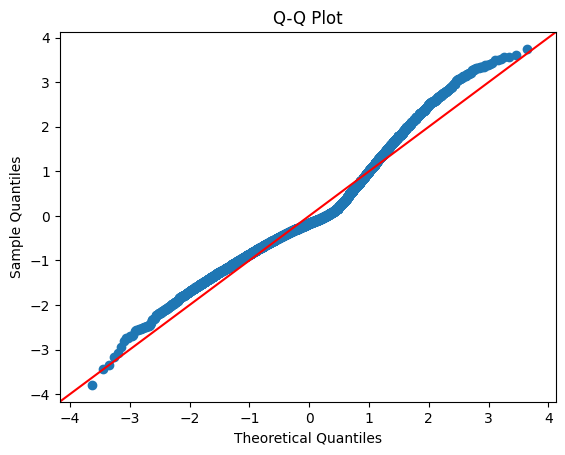

In [42]:
residuals = actual - predicted

plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot')
plt.show()